# Making allele frequency plots

This notebook contains code to process the CRISPResso "allele frequency table" files from base editor validation experiments. The inputs are 2 input files: the first contains metainformation about each sample to make the "allele frequency" file, and the second contains metainformation to compute correlations between the log-normalized read counts. The output of this file are 3 files for each sgRNA / primer pair: 
1. a file containing all alleles and their read counts for each sample
2. a filtered version of (1) that only contains alleles with at least 1% abundance in any sample
3. a file containing the Pearson correlations between log-normalized read counts of each allele with > 100 reads in at least one sample

(1) is the starting file used to show the abundance of specific edits over time (code in BEV_aa_over_time.ipynb). (2) is the starting file used to create allele-level heatmaps (this was done using GraphPad Prism). (3) is the starting file for the plots showing the replicate correlation for validation experiments (actual plots were made using GraphPad Prism).

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../scripts/')
import pandas as pd 

import notebook_functions as nb

pd.set_option('display.max_colwidth', None)

In [4]:
print('Python version: ' + sys.version)

Python version: 3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [5]:
modules = ['pandas', 'numpy']
for module in modules:
    try:
        print(module + ' ' + sys.modules[module].__version__)
    except:
        print(module + ' has no __version__ attribute')


pandas 1.2.1
numpy 1.19.5


## User inputs

<font color='blue'> Please follow steps indicated in blue, then run the notebook to generate output files. If the files are formatted as described in the documentation, the code in the 'Functions' section should not need to be altered. </font> 

### Load input files

**Metainformation file** 

<font color='blue'> <b>Step 1:</b> Create metainformation input file in the following format </font> 

**Columns**: 

* **sg** : sg identifier 
* **sgRNA_sequence** : sequence of sgRNA as designed 
* **translation_ref_seq**: reference sequence outputted by CRISPResso formatted such that any intronic sequences are lower-case, exons are upper-case, and UTRs are indicated by square brackets (if applicable) <u> must be sequence on strand that is being translated; may not necessarily be the same strand as the sgRNA sequence</u> 
    * Ex. <font color='grey'>tgtcttttctatgatctctttag</font><font color='green'>GGGTGACCCAGTCTATT</font>
* **primer** : name of primer pair (joined by '\_') used to amplify genomic locus as mentioned in sample name
    * Ex. <font color='purple'>F_C12</font><font color = 'blue'><b>_</b></font><font color='green'>R_C12</font>
* **frame** : frame for translation (manually determined for each sg / primer pair); position of first coding nucleotide in reference sequence within codon; frame can be 1, 2, 3
    * Ex. given reference sequence: tgtcttttctatgatctctttag<font color='green'>**G**</font>G|GTG|ACC|CAG|TCT|ATT 
        since the first coding nucleotide of the reference sequence (<font color='green'><b>G</b></font>) is the 2nd nucleotide in its codon 
        (\_<font color='green'><b>G</b></font>G) &rightarrow; frame = 2
* **first_codon** : first codon for translation 
* **last_codon** : last codon for translation 
* **rev_com** : samples for which reference sequence is on reverse strand 
* **BEV_ref** : reference sample(s) for log-fold change (LFC) calculation (i.e. early time point, empty vector, etc.); if multiple BEV numbers are given, they should be separated by ';', and they will be treated as replicates that will be averaged
* **BEV_test** : test sample(s) for LFC calculation; if multiple BEV numbers are given, they should be separated by ';', and they will be treated as replicates that will be averaged

**Example input:**


| sg      | sgRNA_sequence       | translation_ref_seq                                  | primer        | frame | first_codon| last_codon| rev_com | BEV_ref | BEV_test |
| ------- | -------------------- | ---------------------------------------- | ------------- |  ----|----|---: | ------: | ------- | -------- |
| 397   | GTCACCCCTAAAGAGATCAT | tgtcttttctatgatctctttagGGGTGACCCAGTCTATT |F_C12_R_C12 |  2    |TGG|ATT| True    | 5;6     | 9;10     |


<font color='blue'> <b> Step 1: </b> Enter filepath to metainformation input file here </font> 

In [15]:
# input_file = pd.read_csv('../../RNAtest_BEV_metainformationV1.csv').head(1)
input_filepath = input("Please enter input filepath here: ")
input_file = pd.read_csv(input_filepath)

input_file

,sg,sgRNA_sequence,translation_ref_seq,primer,frame,first_codon,last_codon,rev_com,BEV_ref,BEV_test
0,RNAtest_sample,GGTTGAGAATCCCTGCTTGA,[CGCTCAGCCCCGATGAACCCCTAAACCACAGGTTGAGAATCCCTGCTTGAAGATCAGAAGTTCCAATGCTGGATTACGTC],NaN,NaN,NaN,NaN,NaN,3,6


In [16]:
#check for NaN values i.e. blank rows
if input_file.isnull().values.any(): 
    input_file = nb.clean_input_file(input_file)

In [17]:
nb.check_input_file(input_file)

Checking input file...


1it [00:00, 1634.57it/s]

Guide targets non-coding region


'Input file is correct!'

**Read Count Filter**

In [18]:
global read_count_percent_cutoff
read_count_percent_cutoff_input = input("Please enter percent to use for filtering low read counts here. "
                                  "Common cutoffs are 1-2%. ")
read_count_percent_cutoff = float(read_count_percent_cutoff_input)

Please enter percent to use for filtering low read counts here. Common cutoffs are 1-2%. 1


**Correlation Metainformation file** 

<font color='blue'><b>Step 3:</b> Create correlation input file in the following format  </font> 

**Columns**: 

* **sg** : sg identifier 
* **reps_for_correlation** : semicolon-separated BEV numbers of which to calculate the pairwise Pearson correlation of the log-normalized read counts

**Example input:**
    
| sg      | reps_for_correlation |
| ------- | -------------------: | 
| 397     | 7;8 | 
| 397     | 9;10 | 
| 397     | 11;12 | 


<font color='blue'><b>Step 4:</b> Enter filepath to correlation input file here. If you do not have one, please leave the field blank and press <kbd>return</kbd> or <kbd>enter</kbd>  </font> 

In [19]:
# corr_input = pd.read_csv('../../AudreyData/TP53/SampleCorrelation_input_TP53_ABE.csv')
corr_corr_inputpath = input("Please enter correlation input filepath here: ")
if corr_corr_inputpath == '':
    corr_input = None
    print('No correlation input file.')
else:
    corr_input = pd.read_csv(corr_corr_inputpath)
    corr_input.head()

Please enter correlation input filepath here: 
No correlation input file.


### Specify folder filepaths 

<font color='blue'><b>Step 5:</b> Enter filepath to folder containing CRISPResso output files here. Please make sure that the filepath does not begin with a '/' but does end in a '/'.  </font> 

Please note that each folder containing CRISPResso output files for individual samples within the given folder should be named in the format 'CRISPResso_on_'+bev+'\_'+
primer, where bev = ('BEV' or 'NGBEV') + sample_number and primer = primer name. 
Ex. <font color='grey'>CRISPResso_on</font><font color='purple'>_BEV_001</font><font color='green'>_F2_R2</font>

In [20]:
global bev_string_id
bev_string_id = input('Please enter either \'BEV\' or \'NGBEV\' to indicate which string is used when naming your CRISPResso files.')
if ((bev_string_id != 'BEV') and (bev_string_id != 'NGBEV')):
    raise Exception('Invalid input. Please enter either \'BEV\' or \'NGBEV\' to specify which string is used in CRISPResso file names. Be careful not to add any extra spaces.')



Please enter either 'BEV' or 'NGBEV' to indicate which string is used when naming your CRISPResso files.BEV


In [21]:
global CRISPResso_filepath 
# CRISPResso_filepath = '../../RJS_RNAtest_crispresso-output/CRISPRessoBatch_on_RJS_Meljuso_CD274_RNAtest_batch/'
CRISPResso_filepath = input("Please enter CRISPResso filepath here: ")
CRISPResso_filepath = nb.check_folder_filepath(CRISPResso_filepath)
print(CRISPResso_filepath)

../../RJS_RNAtest_crispresso-output/CRISPRessoBatch_on_RJS_Meljuso_CD274_RNAtest_batch/


<font color='blue'><b>Step 6:</b> Enter filepath to folder where the files generated by this notebook will be stored. Please make sure that the filepath does not begin with a '/' but does end in a '/'. If the folders in this file path do not currently exist, they will be created when the notebook is run.  </font> 

In [22]:
# Filepath to store allele_freq output tables 
global output_filepath 
# output_filepath = '../../RemovingPrimerInput_NotebookUpdate/allele_freq'
output_filepath = input("Please enter output folder filepath here: ")
output_filepath = nb.check_folder_filepath(output_filepath)
print(output_filepath)

../../RemovingPrimerInput_NotebookUpdate/allele_freq/


### Run functions

Now, we run the two input files and produce allele tables for all sgRNAs.

In [23]:
nb.run(input_file,corr_input, bev_string_id, CRISPResso_filepath, read_count_percent_cutoff, output_filepath)

RNAtest_sample
[3, 6]
../../RJS_RNAtest_crispresso-output/CRISPRessoBatch_on_RJS_Meljuso_CD274_RNAtest_batch/CRISPResso_on_BEV_003/Alleles_frequency_table_around_sgRNA_GGTTGAGAATCCCTGCTTGA.txt
../../RJS_RNAtest_crispresso-output/CRISPRessoBatch_on_RJS_Meljuso_CD274_RNAtest_batch/CRISPResso_on_BEV_006/Alleles_frequency_table_around_sgRNA_GGTTGAGAATCCCTGCTTGA.txt
                                                                   Aligned_Sequence  \
0  --------------------------CACAGGTTGGGAATCCCAGCTTGAAGATCAGAAGTTCCAATGCTGGATTACGTC   
1  --------------------------CACAGGTTGGGAATCCCTGCTTGAAGATCAGAAGGTCCAATGCTGGATTACGTC   

                                                                 Reference_Sequence  \
0  CGCTCAGCCCCGATGAACCCCTAAACCACAGGTTGAGAATCCCTGCTTGAAGATCAGAAGTTCCAATGCTGGATTACGTC   
1  CGCTCAGCCCCGATGAACCCCTAAACCACAGGTTGAGAATCCCTGCTTGAAGATCAGAAGTTCCAATGCTGGATTACGTC   

   #Reads_BEV_003  %Reads_BEV_003  #Reads_BEV_006  %Reads_BEV_006  
0             1.0        0.000155           

## Heatmap

Finally, we generate allele-level heat maps annotated with corresponding allele amino acid sequences and tables with average % reads for each allele at early and late time points.

By default, early time point samples are considered to be the same as the BEV_ref samples and the late time point samples are considered to be the BEV_test samples. If this is not the case (e.g.,  BEV_test samples span multiple time points), please upload a file with the following columns: 

**Columns**: 

* **sg** : sg identifier 
* **Time point** : string that identifies time point 
* **BEV_num** : semicolon-separated BEV numbers corresponding to samples at that time point 

**Example input:**
    
| sg      |time_point | BEV_nums |
| ------- |------- | -------------------: | 
| 397     |D8      |  7;8 | 
| 397     |D14      | 9;10 | 
| 397     |D21      | 11;12 | 


In [25]:
# User inputs column labels and heatmap filename
global time1
time1 = input("Please input the label for the first %Reads column (e.g. D7, low)")
global time2
time2 = input("Please input the label for the second %Reads column (e.g. D21, high)")
global heatmap_filename
heatmap_filename = input("Please enter the filename for the heatmap.")

../../RemovingPrimerInput_NotebookUpdate/allele_freq/Figures/RNAtest_noprimer_heatmap.pdf
+ indicates that there are additional UTR and/or intronic mutations in this allele. Please check the output tables for further details.


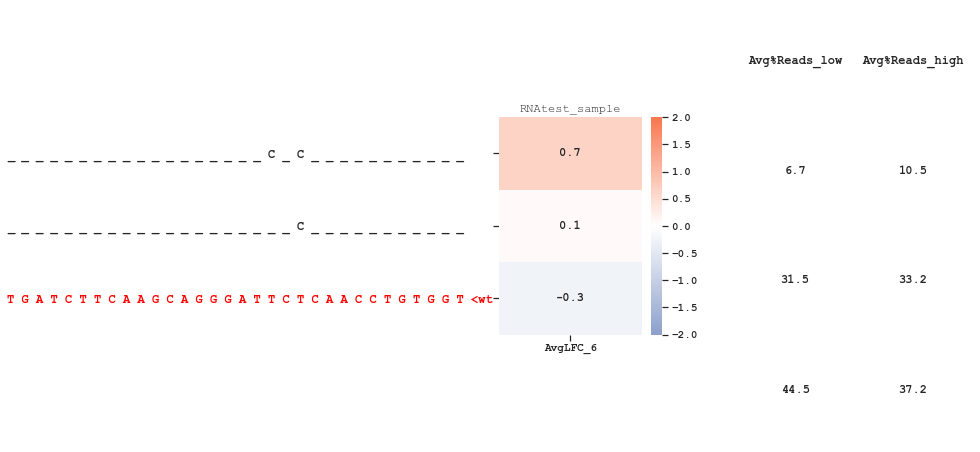

In [26]:
# Run heatmap function
nb.heatmaps(df = input_file,
         vmin = -2,
         vmax = 2,
         filepath = output_filepath,
         time1 = time1,
         time2 = time2,
         filename = heatmap_filename
        )